<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/MLP/4-4-Zero-shot_classification_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Zero-shot classification with embeddings

In this notebook we will classify the sentiment of reviews using embeddings and zero labeled data! The dataset is created in the [Get_embeddings_from_dataset Notebook](Get_embeddings_from_dataset.ipynb).

We'll define positive sentiment to be 4- and 5-star reviews, and negative sentiment to be 1- and 2-star reviews. 3-star reviews are considered neutral and we won't use them for this example.

We will perform zero-shot classification by embedding descriptions of each class and then comparing new samples to those class embeddings.

In [1]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os

userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
api_key = os.getenv("OPENAI_API_KEY")

In [3]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R' -O fine_food_reviews_with_embeddings_1k.csv

--2024-10-03 13:56:45--  https://drive.google.com/uc?export=download&id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R
Resolving drive.google.com (drive.google.com)... 142.251.2.100, 142.251.2.113, 142.251.2.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R&export=download [following]
--2024-10-03 13:56:45--  https://drive.usercontent.google.com/download?id=1jfmC2bkgmsjC56xlOeNyrIOytxPMJP6R&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35255462 (34M) [application/octet-stream]
Saving to: ‘fine_food_reviews_with_embeddings_1k.csv’

fine_food_reviews_w 100%[===================

In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.metrics import classification_report

EMBEDDING_MODEL = "text-embedding-3-small"

datafile_path = "./fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})


<ipython-input-4-59a52aedc36e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})


### Zero-Shot Classification
To perform zero shot classification, we want to predict labels for our samples without any training. To do this, we can simply embed short descriptions of each label, such as positive and negative, and then compare the cosine distance between embeddings of samples and label descriptions.

The highest similarity label to the sample input is the predicted label. We can also define a prediction score to be the difference between the cosine distance to the positive and to the negative label. This score can be used for plotting a precision-recall curve, which can be used to select a different tradeoff between precision and recall, by selecting a different threshold.

In [6]:
!mkdir utils

In [7]:
!wget https://raw.githubusercontent.com/openai/openai-cookbook/main/examples/utils/embeddings_utils.py -O utils/embeddings_utils.py

--2024-10-03 13:58:01--  https://raw.githubusercontent.com/openai/openai-cookbook/main/examples/utils/embeddings_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8172 (8.0K) [text/plain]
Saving to: ‘utils/embeddings_utils.py’

utils/embeddings_ut 100%[===================>]   7.98K  --.-KB/s    in 0s      

2024-10-03 13:58:01 (98.2 MB/s) - ‘utils/embeddings_utils.py’ saved [8172/8172]



              precision    recall  f1-score   support

    negative       0.14      0.87      0.24       136
    positive       0.76      0.07      0.13       789

    accuracy                           0.19       925
   macro avg       0.45      0.47      0.18       925
weighted avg       0.67      0.19      0.15       925



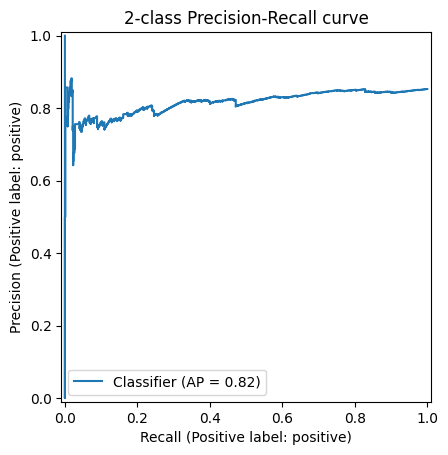

In [8]:
from utils.embeddings_utils import cosine_similarity, get_embedding
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'],
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, model=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach(labels=['negative', 'positive'], model=EMBEDDING_MODEL)


We can see that this classifier already performs extremely well. We used similarity embeddings, and the simplest possible label name. Let's try to improve on this by using more descriptive label names, and search embeddings.

              precision    recall  f1-score   support

    negative       0.14      0.93      0.25       136
    positive       0.81      0.06      0.10       789

    accuracy                           0.18       925
   macro avg       0.48      0.49      0.18       925
weighted avg       0.72      0.18      0.13       925



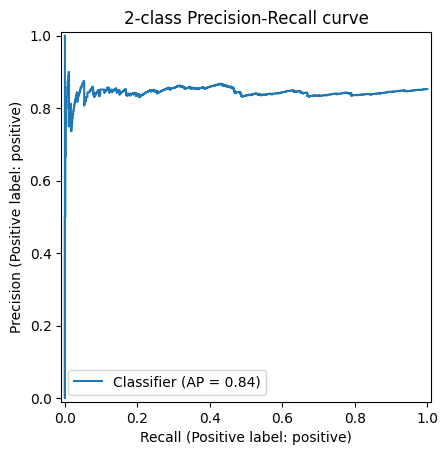

In [9]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])


Using the search embeddings and descriptive names leads to an additional improvement in performance.

              precision    recall  f1-score   support

    negative       0.14      0.93      0.25       136
    positive       0.81      0.06      0.10       789

    accuracy                           0.18       925
   macro avg       0.48      0.49      0.18       925
weighted avg       0.72      0.18      0.13       925



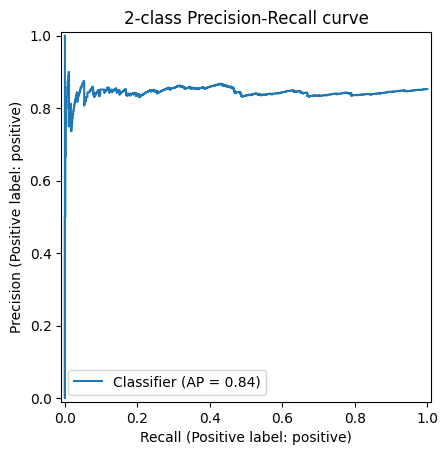

In [10]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])


As shown above, zero-shot classification with embeddings can lead to great results, especially when the labels are more descriptive than just simple words.